# ML WORKFLOW: Canadian Housing Dataset  
Baseline Linear Regression and Advanced XGBoost Model Comparison

## 1. LOAD dataset with log-transformed price  
- Source: `Cleaned_HouseListings_with_log_price.csv`   
- Dataset has been cleaned and preprocessed in prior steps

In [2]:
# Import basic libraries for data handling and visualization
import pandas as pd                    # DataFrames and data manipulation
import numpy as np                     # Numerical operations
import matplotlib.pyplot as plt        # Plotting library
import seaborn as sns                  # Statistical plots
from IPython.display import display

# Load preprocessed dataset with 'log_price' already included
data = pd.read_csv("Cleaned_HouseListings_with_log_price.csv")

# Preview relevant features including the log-transformed target
display(data[["Number_Beds", "Number_Baths", "Price", "log_price"]].head())

# Create a working copy to prepare for modeling
ml_data = data.copy()

# Display dataset composition and coverage
print("Provinces in dataset:", ml_data["Province"].unique())
print("Number of unique cities:", ml_data["City"].nunique())
print("Dataset shape:", ml_data.shape)

,Number_Beds,Number_Baths,Price,log_price
0,3,2,779900.0,5.892039
1,3,1,799999.0,5.903089
2,2,2,799900.0,5.903036
3,4,2,1200000.0,6.079181
4,1,1,668800.0,5.825296


Provinces in dataset: ['ON' 'BC' 'AB' 'MB' 'SK' 'NL' 'NB' 'QC' 'NS']
Number of unique cities: 45
Dataset shape: (32627, 10)


## Step 2: Encode Categorical Variables (Province and City)

This step encodes the categorical variables `Province` and `City` using one-hot encoding. 

To prevent multicollinearity, we use `drop_first=True` so that one category is used as the baseline. Since the dataset includes 45 unique cities and has over 32,000 entries, we include all cities  without grouping or filtering to fully leverage the available information.


In [3]:

# Generate dummy variables for Province and City, dropping the first category in each to avoid redundancy
province_dummies = pd.get_dummies(ml_data["Province"], prefix="Prov", drop_first=True)
city_dummies = pd.get_dummies(ml_data["City"], prefix="City", drop_first=True)

# Concatenate all input features into a single matrix X
X = pd.concat([
    ml_data[["Number_Beds", "Number_Baths", "Latitude"]],
    province_dummies,
    city_dummies
], axis=1)

# Define the target variable
y = ml_data["log_price"]

# Display resulting shape
print("Feature matrix shape (X):", X.shape)
print("Target variable shape (y):", y.shape)

Feature matrix shape (X): (32627, 55)
Target variable shape (y): (32627,)


## 3. Split the Dataset for Model Training and Evaluation (Testing)

To evaluate model performance, we split the data into two subsets:

- **Training set (80%)**: used to train the model.
- **Test set (20%)**: used to evaluate how well the model generalizes to unseen data.

We will predict `log_price` using a combination of numerical features 
(`Number_Beds`, `Number_Baths`, `Latitude`) and one-hot encoded categorical variables 
(`Province`, `City`).

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
)

# Display shapes of the split sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (26101, 55)
Test set size: (6526, 55)


## 4. Train a Baseline Linear Regression Model

We begin by training a **Linear Regression** model to establish a baseline for performance.

### Why Linear Regression?
- Simple and interpretable model for initial benchmarking.
- Helps identify linear relationships and potential feature issues.
- Serves as a diagnostic tool before applying more complex models.

We train the model using:
- Numerical features: `Number_Beds`, `Number_Baths`, `Latitude`
- One-hot encoded categorical variables: `Province`, `City`

### Evaluation Metrics:
- **R² (coefficient of determination)**: Proportion of variance in the target explained by the model (higher = better).
- **RMSE (root mean squared error)**: Average prediction error in log₁₀ scale (lower = better).

These metrics provide a quantitative view of model fit and prediction error on unseen data.

In [6]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression       # Linear regression model
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics
import numpy as np                                       # Numerical operations for RMSE


# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)  # Train the model on the training set

# Predict on the test set
y_pred = lr_model.predict(X_test)  # Predict house prices (log scale)

# Evaluate performance using R² and RMSE
r2 = r2_score(y_test, y_pred)  # How well predictions explain variance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Average prediction error in log10 scale

# Print evaluation results
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R-squared (R²): 0.6443
Root Mean Squared Error (RMSE): 0.1820


**Model Evaluation Results**

The baseline linear regression model achieved an **R² of 0.6443**, meaning it explains about **64% of the variance** in log-transformed housing prices. This suggests a reasonably strong linear relationship between the input features and the target variable.

The **RMSE is 0.1820** in log₁₀ scale, indicating an average prediction error of approximately **±52%** when converted back to the original price scale.  

These results show a solid performance for a linear baseline and provides a reliable benchmark for evaluating more complex models.

## 5. Visualize Predictions: Actual vs. Predicted (Log Scale)

This scatter plot compares the model’s predicted `log_price` values with the actual values from the test set,  based on the linear regression model trained in the previous step.

- Points along the diagonal line represent **perfect predictions**.
- Deviations from this line indicate **prediction errors**.
- This plot helps visually assess how well the linear model generalizes to new, unseen data.

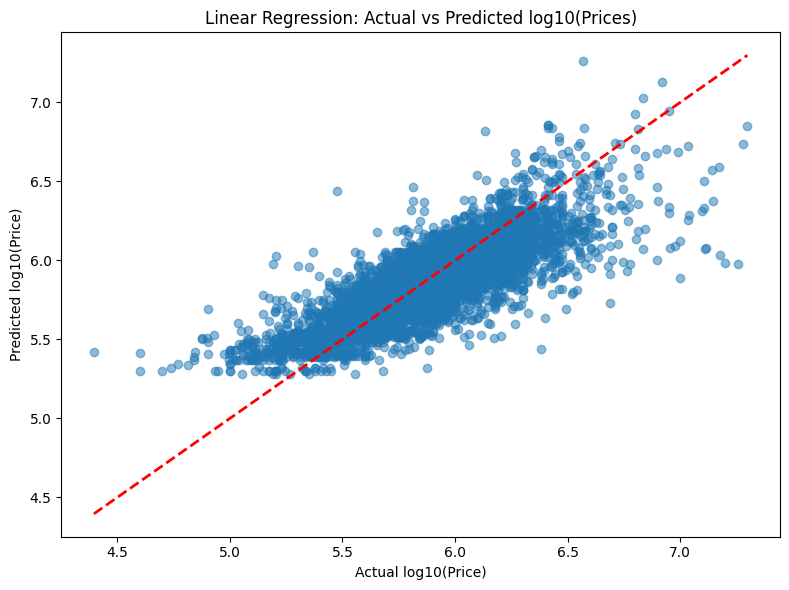

In [7]:
import matplotlib.pyplot as plt  # Library for plotting

# Scatter plot: Predicted vs Actual values
plt.figure(figsize=(8, 6))  # Set figure size

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred, alpha=0.5)  # Semi-transparent points for better readability

# Add reference diagonal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # Red dashed line

# Add axis labels and plot title
plt.xlabel("Actual log10(Price)")       # x-axis label
plt.ylabel("Predicted log10(Price)")    # y-axis label
plt.title("Linear Regression: Actual vs Predicted log10(Prices)")  # Title

# Improve layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

### Interpretation: Actual vs Predicted Plot

This scatter plot compares the **actual log-transformed house prices** (`log_price`, x-axis) with the **predicted values** from the linear regression model (y-axis).

- The **red dashed line** represents perfect predictions (`y = x`).
- Points that fall **close to the line** indicate accurate predictions.
- Points **above** the line are **overestimations**; points **below** are **underestimations**.

We observe a strong linear pattern with most points clustered near the diagonal, especially in the mid-price range.  
The spread increases slightly at both lower and higher price extremes, suggesting the model captures the general trend well but may miss some local variations — a common behavior for linear models when applied to real-world data.

### Residual Plot: Error Analysis

The residual plot helps evaluate how well the Linear Regression model fits the data by visualizing the prediction **errors** (residuals).

- A **residual** is the difference between the actual value and the predicted value.
- Ideally, residuals should be **randomly scattered around zero** — this suggests a good fit.
- **Patterns or curves** in the residuals may indicate that the model is missing important relationships or that a non-linear model may be more appropriate.

This diagnostic is useful to assess if Linear Regression assumptions hold or if a more advanced model is needed.


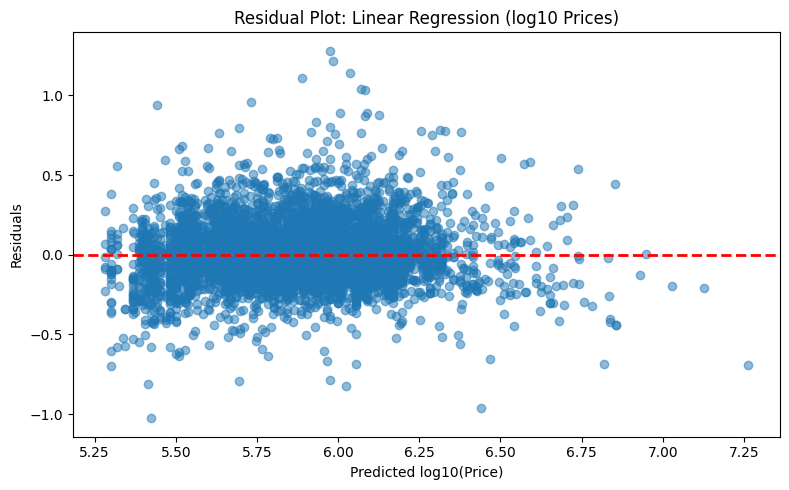

In [9]:
import matplotlib.pyplot as plt  # Already imported earlier

# Compute residuals: actual - predicted
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Reference line at zero
plt.xlabel("Predicted log10(Price)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Linear Regression (log10 Prices)")
plt.tight_layout()
plt.show()

### Residual Plot Interpretation

The residual plot shows that most prediction errors are centered around zero,  indicating that the linear regression model performs reasonably well across the mid-range of prices.

- Residuals appear randomly scattered, which is a good sign.
- There is **slight funneling** as predicted values increase, suggesting **mild heteroscedasticity**—the model's error grows slightly for higher-priced homes.
- A few larger residuals indicate the presence of **outliers** or price dynamics not captured by the linear model.

Overall, the model fits the data well but may benefit from a more flexible approach to handle variance at the upper end of the price range.

## 6. Simulate a Real Prediction

With the linear regression model trained, we can now simulate predictions for new house listings.

This simulation uses a combination of input features — including the number of bedrooms, bathrooms, location (latitude), and one-hot encoded province and city — to estimate housing prices.

The model outputs the predicted `log10(Price)`, which is then converted to the actual price in dollars for easier interpretation.

In [49]:
# 1: Show available provinces
print("Available Provinces:", sorted(ml_data["Province"].unique()))

# 1.1: User-defined input
user_input = {
    "Province": "BC",
    "City": "Victoria",
    "Number_Beds": 3,
    "Number_Baths": 2
}

# 1.2: Top cities in selected province
selected_province = user_input["Province"]
cities_in_province = (
    ml_data[ml_data["Province"] == selected_province]["City"]
    .value_counts()
    .head(3)
)

print(f"\nTop Cities in {selected_province}:")
print(f"{'City':<20} | {'Listings':<8}")
print("-" * 32)
for city, count in cities_in_province.items():
    print(f"{city:<20} | {count:<8}")

# 1.3: Most common bed/bath combinations
common_configs = (
    ml_data.groupby(["Number_Beds", "Number_Baths"])
    .size()
    .sort_values(ascending=False)
    .head(4)
)

print("\nMost Common Bed/Bath Combinations:")
print(f"{'Beds':<4} | {'Baths':<5} | {'Listings':<8}")
print("-" * 32)
for (beds, baths), count in common_configs.items():
    print(f"{beds:<4} | {baths:<5} | {count:<8}")

# 2–5: Predict price for single user_input
latitude = ml_data[ml_data["City"] == user_input["City"]]["Latitude"].mean()

if np.isnan(latitude):
    print(f"Warning: City '{user_input['City']}' not found in dataset.")
else:
    dummy_row = pd.DataFrame(data=np.zeros((1, len(X.columns))), columns=X.columns)
    dummy_row.at[0, "Number_Beds"] = user_input["Number_Beds"]
    dummy_row.at[0, "Number_Baths"] = user_input["Number_Baths"]
    dummy_row.at[0, "Latitude"] = latitude

    province_col = f"Prov_{user_input['Province']}"
    city_col = f"City_{user_input['City']}"

    if province_col in dummy_row.columns:
        dummy_row.at[0, province_col] = 1
    else:
        print(f"Warning: Province '{user_input['Province']}' not found in one-hot columns.")

    if city_col in dummy_row.columns:
        dummy_row.at[0, city_col] = 1
    else:
        print(f"Warning: City '{user_input['City']}' not found in one-hot columns.")

    predicted_log = lr_model.predict(dummy_row)[0]
    predicted_price = 10 ** predicted_log

    print("\nPredicted Price for Custom Listing:")
    print("-" * 40)
    print(f"{'Location':<15}: {user_input['City']}, {user_input['Province']}")
    print(f"{'Configuration':<15}: {user_input['Number_Beds']} Bed / {user_input['Number_Baths']} Bath")
    #print(f"{'Latitude':<15}: {latitude:.4f}")
    #print(f"{'log10(Price)':<15}: {predicted_log:.4f}")
    print(f"{'Predicted Price':<15}: ${predicted_price:,.0f}")

# 6: Compare same home in 3 provinces
print(f"\nComparison: {user_input['Number_Beds']} Bed / {user_input['Number_Baths']} Bath Across Cities")
print("-" * 40)
#print(f"{'City':<12} | {'Province':<8} | {'Latitude':<9} | {'log10(P)':<9} | {'Price ($)':<12}")
print(f"{'City':<12} | {'Province':<8} | {'Predicted Price ($)':<12}")
print("-" * 40)

comparison_list = [
    {"Province": "ON", "City": "Toronto"},
    {"Province": "BC", "City": "Vancouver"},
    {"Province": "AB", "City": "Calgary"}
]

for entry in comparison_list:
    prov = entry["Province"]
    city = entry["City"]
    lat = ml_data[ml_data["City"] == city]["Latitude"].mean()

    if np.isnan(lat):
        print(f"{city:<12} | {prov:<8} | {'N/A':<9} | {'N/A':<9} | {'N/A':<12}")
        continue

    row = pd.DataFrame(data=np.zeros((1, len(X.columns))), columns=X.columns)
    row.at[0, "Number_Beds"] = user_input["Number_Beds"]
    row.at[0, "Number_Baths"] = user_input["Number_Baths"]
    row.at[0, "Latitude"] = lat

    prov_col = f"Prov_{prov}"
    city_col = f"City_{city}"
    if prov_col in row.columns:
        row.at[0, prov_col] = 1
    if city_col in row.columns:
        row.at[0, city_col] = 1

    log_pred = lr_model.predict(row)[0]
    price = 10 ** log_pred

    #print(f"{city:<12} | {prov:<8} | {lat:.4f}   | {log_pred:.4f} | ${price:,.0f}")
    print(f"{city:<12} | {prov:<8} | ${price:,.0f}")

Available Provinces: ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'QC', 'SK']

Top Cities in BC:
City                 | Listings
--------------------------------
New Westminster      | 1306    
Burnaby              | 1291    
Vancouver            | 1284    

Most Common Bed/Bath Combinations:
Beds | Baths | Listings
--------------------------------
2    | 2     | 4516    
3    | 2     | 3786    
3    | 3     | 3679    
4    | 3     | 2658    

Predicted Price for Custom Listing:
----------------------------------------
Location       : Victoria, BC
Configuration  : 3 Bed / 2 Bath
Predicted Price: $884,881

Comparison: 3 Bed / 2 Bath Across Cities
----------------------------------------
City         | Province | Predicted Price ($)
----------------------------------------
Toronto      | ON       | $1,000,063
Vancouver    | BC       | $1,277,401
Calgary      | AB       | $471,105


### Interpretation of Predicted Prices (3 Bed / 2 Bath)

The table above compares predicted prices for a standard 3-bedroom, 2-bathroom home across three major Canadian cities: Toronto (ON), Vancouver (BC), and Calgary (AB).

This configuration was chosen because it is among the most frequent in the dataset, offering strong support for reliable predictions.

### Observations:
- **Vancouver (BC)** has the highest predicted price (~\$1.28M), reflecting its premium real estate market.
- **Toronto (ON)** follows with a predicted price of ~\$1.00M, consistent with its status as a major urban center.
- **Calgary (AB)** shows the lowest price (~\$471K), highlighting more affordable housing conditions.

Even with identical home features, prices vary substantially by location — confirming the model's ability to capture geographic price trends.

## 7. Train an Advanced Model: XGBoost Regressor

We now train an XGBoost model to compare performance against the baseline Linear Regression.

## 7. Train and Evaluate an Advanced Model: XGBoost Regressor

We now train an XGBoost regression model to compare against the baseline Linear Regression.

- XGBoost is a powerful tree-based algorithm that handles non-linear patterns and feature interactions.
- We will use the same training and testing split (`X_train`, `X_test`) for a fair comparison.
- Performance will be measured using **R²** and **RMSE** metrics, just like before.

In [46]:
# Import required libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ---------------------------------------------------
# Train an XGBoost Regressor on the same training data
# ---------------------------------------------------

# 1. Initialize the model with common hyperparameters
# - n_estimators: number of boosting rounds (trees)
# - max_depth: maximum depth of each tree
# - learning_rate: step size shrinkage used in update
# - random_state: ensures reproducibility
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 2. Fit the model on the training set
xgb_model.fit(X_train, y_train)

# 3. Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluate performance
r2_xgb = r2_score(y_test, y_pred_xgb)                     # Coefficient of determination
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))  # Root Mean Squared Error

# 5. Output results
print(" XGBoost Regressor Performance:")
print(f"- R² Score: {r2_xgb:.4f}")
print(f"- RMSE:     {rmse_xgb:.4f}")

 XGBoost Regressor Performance:
- R² Score: 0.6955
- RMSE:     0.1684


###  Interpretation: XGBoost Regressor Performance vs Linear Regression Performance

The XGBoost Regressor achieved better performance than the baseline Linear Regression model.

| Metric        | Linear Regression | XGBoost Regressor | Improvement |
|---------------|-------------------|-------------------|-------------|
| **R² Score**  | 0.6443            | **0.6955**        |   +0.0512   |
| **RMSE**      | 0.1820            | **0.1684**        |   -0.0136   |

These results confirm that **XGBoost captures more complex, non-linear relationships** in the data, leading to more accurate predictions.

### Key Takeaways:
- The model explains more variance (**R² ↑**) and reduces average error (**RMSE ↓**).
- Improvements are achieved using the same input features — showing that the model itself matters.
- This makes XGBoost a **stronger candidate** for real-world housing price prediction tasks.

We will further analyze this model with visual diagnostics to verify how well it generalizes and handles prediction errors.

## 7. Visualize Predictions: Actual vs. Predicted (XGBoost Model)

This scatter plot compares the XGBoost model’s predicted `log_price` values with the actual values from the test set.

- Points along the red diagonal line indicate **perfect predictions**.
- Points that deviate from this line represent **prediction errors**.
- Compared to linear regression, XGBoost may capture more complex patterns, which could result in predictions closer to the ideal line.

This visualization helps evaluate how well the XGBoost model generalizes to new, unseen data.

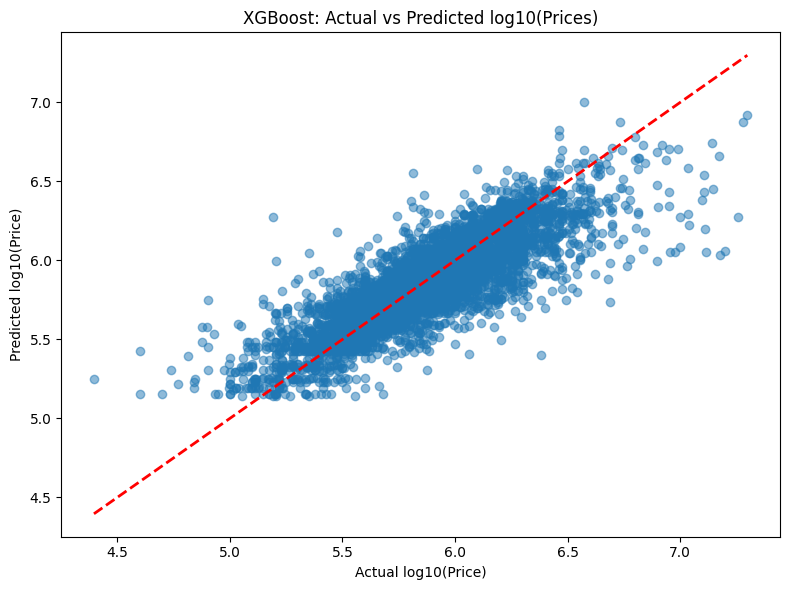

In [47]:
import matplotlib.pyplot as plt

# Scatter plot: Predicted vs Actual log10(price)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)  # puntos semitransparentes
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # línea diagonal
plt.xlabel("Actual log10(Price)")
plt.ylabel("Predicted log10(Price)")
plt.title("XGBoost: Actual vs Predicted log10(Prices)")
plt.tight_layout()
plt.show()

### Interpretation: Actual vs Predicted Plot (XGBoost)

The scatter plot shows the relationship between actual and predicted `log10(Price)` using the XGBoost model.

- Most points closely follow the red diagonal line, indicating **accurate predictions**.
- Compared to linear regression, the spread is slightly tighter, especially in mid-price ranges.
- There are still some outliers and deviations at higher prices, but the overall alignment suggests **improved generalization**.

These results confirm that XGBoost captures more complex patterns in the housing data, leading to better predictive accuracy.

### Residual Plot: Error Analysis (XGBoost)

This residual plot helps assess how well the XGBoost model fits the data by visualizing the **prediction errors** (residuals):

- A **residual** is the difference between the actual value and the predicted value.
- Ideally, residuals should appear **randomly scattered around zero** — this suggests good predictive performance.
- **Patterns or systematic curves** in the residuals may reveal issues like non-linearities or missing interactions.

Compared to the linear regression model, XGBoost often reduces structure in residuals, indicating it captures more complex relationships in the data.

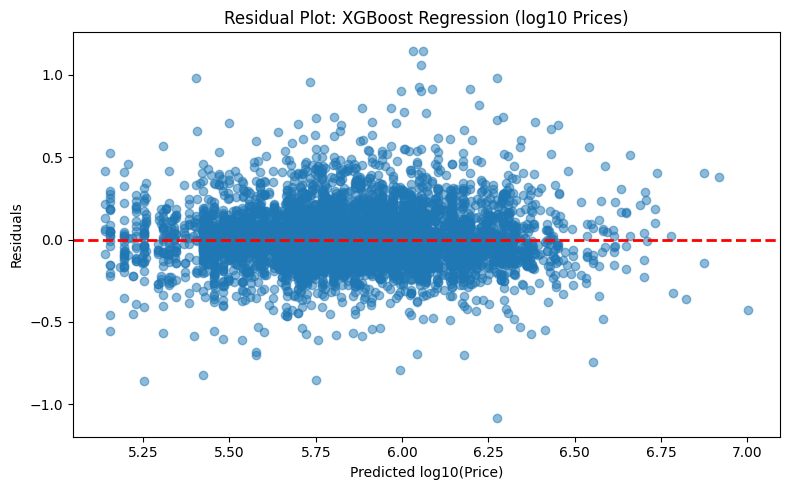

In [48]:
import matplotlib.pyplot as plt

# Compute residuals: actual - predicted
residuals_xgb = y_test - y_pred_xgb

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 5))

# Scatter plot of residuals
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Reference line at zero

# Axis labels and title
plt.xlabel("Predicted log10(Price)")
plt.ylabel("Residuals")
plt.title("Residual Plot: XGBoost Regression (log10 Prices)")

plt.tight_layout()
plt.show()

### Interpretation: Residual Plot for XGBoost

The residuals are more tightly clustered around the zero line compared to the linear regression model, suggesting:

- **Improved fit**: XGBoost captures more variance in the data, as shown by the narrower vertical spread.
- **Less structure**: There's no obvious curve or pattern in the residuals, indicating fewer unmodeled relationships.
- **Better performance at extremes**: The model handles high-priced properties slightly better, with reduced error spread at the right end.

This pattern confirms that the XGBoost model better captures complex, non-linear relationships — a good sign for modeling real estate prices.

## 6. Simulate a Real Prediction (XGBoost)

Now that the XGBoost regression model has been trained, we can simulate predictions for new house listings using real-world feature combinations.

This step allows us to:
- Predict the price of a custom listing based on selected inputs (province, city, number of beds and baths).
- Display the top cities and most frequent configurations to guide realistic user input.
- Compare how the same home configuration would be priced in three major Canadian cities across different provinces.

The goal is to understand how geographic location affects house prices, even when the home features remain constant.


In [50]:
# 1: Show available provinces
print("Available Provinces:", sorted(ml_data["Province"].unique()))

# 1.1: User-defined input
user_input = {
    "Province": "BC",
    "City": "Victoria",
    "Number_Beds": 3,
    "Number_Baths": 2
}

# 1.2: Top cities in selected province
selected_province = user_input["Province"]
cities_in_province = (
    ml_data[ml_data["Province"] == selected_province]["City"]
    .value_counts()
    .head(3)
)

print(f"\nTop Cities in {selected_province}:")
print(f"{'City':<20} | {'Listings':<8}")
print("-" * 32)
for city, count in cities_in_province.items():
    print(f"{city:<20} | {count:<8}")

# 1.3: Most common bed/bath combinations
common_configs = (
    ml_data.groupby(["Number_Beds", "Number_Baths"])
    .size()
    .sort_values(ascending=False)
    .head(4)
)

print("\nMost Common Bed/Bath Combinations:")
print(f"{'Beds':<4} | {'Baths':<5} | {'Listings':<8}")
print("-" * 32)
for (beds, baths), count in common_configs.items():
    print(f"{beds:<4} | {baths:<5} | {count:<8}")

# 2–5: Predict price for single user_input
latitude = ml_data[ml_data["City"] == user_input["City"]]["Latitude"].mean()

if np.isnan(latitude):
    print(f"Warning: City '{user_input['City']}' not found in dataset.")
else:
    dummy_row = pd.DataFrame(data=np.zeros((1, len(X.columns))), columns=X.columns)
    dummy_row.at[0, "Number_Beds"] = user_input["Number_Beds"]
    dummy_row.at[0, "Number_Baths"] = user_input["Number_Baths"]
    dummy_row.at[0, "Latitude"] = latitude

    province_col = f"Prov_{user_input['Province']}"
    city_col = f"City_{user_input['City']}"

    if province_col in dummy_row.columns:
        dummy_row.at[0, province_col] = 1
    else:
        print(f"Warning: Province '{user_input['Province']}' not found in one-hot columns.")

    if city_col in dummy_row.columns:
        dummy_row.at[0, city_col] = 1
    else:
        print(f"Warning: City '{user_input['City']}' not found in one-hot columns.")

    predicted_log = xgb_model.predict(dummy_row)[0]
    predicted_price = 10 ** predicted_log

    print("\nPredicted Price for Custom Listing:")
    print("-" * 40)
    print(f"{'Location':<15}: {user_input['City']}, {user_input['Province']}")
    print(f"{'Configuration':<15}: {user_input['Number_Beds']} Bed / {user_input['Number_Baths']} Bath")
    print(f"{'Predicted Price':<15}: ${predicted_price:,.0f}")

# 6: Compare same home in 3 provinces
print(f"\nComparison: {user_input['Number_Beds']} Bed / {user_input['Number_Baths']} Bath Across Cities")
print("-" * 40)
print(f"{'City':<12} | {'Province':<8} | {'Predicted Price ($)':<12}")
print("-" * 40)

comparison_list = [
    {"Province": "ON", "City": "Toronto"},
    {"Province": "BC", "City": "Vancouver"},
    {"Province": "AB", "City": "Calgary"}
]

for entry in comparison_list:
    prov = entry["Province"]
    city = entry["City"]
    lat = ml_data[ml_data["City"] == city]["Latitude"].mean()

    if np.isnan(lat):
        print(f"{city:<12} | {prov:<8} | {'N/A':<12}")
        continue

    row = pd.DataFrame(data=np.zeros((1, len(X.columns))), columns=X.columns)
    row.at[0, "Number_Beds"] = user_input["Number_Beds"]
    row.at[0, "Number_Baths"] = user_input["Number_Baths"]
    row.at[0, "Latitude"] = lat

    prov_col = f"Prov_{prov}"
    city_col = f"City_{city}"
    if prov_col in row.columns:
        row.at[0, prov_col] = 1
    if city_col in row.columns:
        row.at[0, city_col] = 1

    log_pred = xgb_model.predict(row)[0]
    price = 10 ** log_pred

    print(f"{city:<12} | {prov:<8} | ${price:,.0f}")

Available Provinces: ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'QC', 'SK']

Top Cities in BC:
City                 | Listings
--------------------------------
New Westminster      | 1306    
Burnaby              | 1291    
Vancouver            | 1284    

Most Common Bed/Bath Combinations:
Beds | Baths | Listings
--------------------------------
2    | 2     | 4516    
3    | 2     | 3786    
3    | 3     | 3679    
4    | 3     | 2658    

Predicted Price for Custom Listing:
----------------------------------------
Location       : Victoria, BC
Configuration  : 3 Bed / 2 Bath
Predicted Price: $1,008,785

Comparison: 3 Bed / 2 Bath Across Cities
----------------------------------------
City         | Province | Predicted Price ($)
----------------------------------------
Toronto      | ON       | $1,061,786
Vancouver    | BC       | $1,556,998
Calgary      | AB       | $463,461


### Interpretation of XGBoost Predictions (3 Bed / 2 Bath)

The table above shows the predicted prices for a **3-bedroom, 2-bathroom** home — one of the most common configurations in the dataset — across three major Canadian cities:

- **Vancouver (BC)** has the highest predicted price at **$1.56M**, reflecting its well-known high property values.
- **Toronto (ON)** follows with a predicted price of **$1.06M**, also consistent with its dense urban housing market.
- **Calgary (AB)** shows a much lower price of **$463K**, highlighting regional affordability differences.

These results confirm that the model effectively captures **geographic pricing disparities**, even when the home features remain constant.

This simulation is useful to illustrate how **location alone** can significantly influence housing prices — a key insight for buyers, investors, or policy analysts.